# Data & Packages

In [ ]:
# embedding
!pip install -U sentence-transformers
# dimensionality reduction
!pip install umap-learn
# clustering 
!pip install hdbscan

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from google.colab import drive


from sentence_transformers import SentenceTransformer
import umap
import hdbscan

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
drive.mount('/content/drive')

## Save Raw Text Data

In [ ]:
# collect all raw data from the drive

input_path = "/content/drive/My Drive/Rebuild my Professor/Ratings/"
files = [file for file in os.listdir(input_path) if file.endswith("csv")]
data = pd.DataFrame()
for file in files:
  df = pd.read_csv(input_path + file, engine="python", index_col = 0)
  data = data.append(df)

In [ ]:
# read the collected documents

sentences = [sent for review in data["rComments"] if type(review)==str and review for sent in sent_tokenize(review)]
print("Length of comments collected:", len(data[data["rComments"].notnull()]), "length of sentences collected", len(sentences))

sentences_small = sentences[::10] # scale down to reduce computation
print(len(sentences_small))

In [ ]:
# save the tokenized sentences collected from 

with open("/content/drive/My Drive/Rebuild my Professor/experiment_sentences_original.npy", "wb") as f:
  np.save(f, sentences)

## Load Text Data 

In [5]:
with open("/content/drive/My Drive/Rebuild my Professor/experiment_sentences_original.npy", "rb") as f:
  sentences = np.load(f)

# Embedding


## Save Embedding

In [ ]:
# use Distilbert as it gives a nice balance between speed and performance

model = SentenceTransformer('distilbert-base-nli-mean-tokens')

In [ ]:
# perform embedding on the sentences

embeddings = model.encode(sentences_small, show_progress_bar=True)

In [ ]:
# save the embeddings locally for future runs

with open("/content/drive/My Drive/Rebuild my Professor/experiment_embeddings_xue.npy", "wb") as f:
  np.save(f, embeddings)

## Load Sentence Embedding

In [6]:
with open("/content/drive/My Drive/Rebuild my Professor/experiment_embeddings_xue.npy", "rb") as f:
  embeddings = np.load(f)

In [7]:
# furthur scale down to fit UMAP algorithm
embeddings = embeddings[::10]
sentences = sentences[::10]

In [8]:
print("The original length is", len(embeddings))

The original length is 77353


In [11]:
import string

# data preprossing in sentences and embeddings
# remove sentences that only has punctuation
empty_count = 0
space_count = 0
punkt_count = 0
total_count = 0
flags = np.zeros(len(sentences), dtype=bool)

for i in range(len(sentences)):
  cur_sentence = sentences[i]
  if not cur_sentence: 
    empty_count += 1
  elif not cur_sentence.strip():
    space_count += 1
  elif cur_sentence[0] in string.punctuation:
    punkt_count += 1
  else:
    flags[i] = True
    continue
  
  total_count += 1

print("Sentences that are empty:", empty_count, ". Sentences that only has white space:", space_count, ". Sentences that starts with punctuation:", punkt_count)
print("Total count", total_count, "should be equal to the sum of the above")

Sentences that are empty: 0 . Sentences that only has white space: 0 . Sentences that starts with punctuation: 903
Total count 903 should be equal to the sum of the above


In [12]:
# apply boolean indexing to sentences and embedding
sentences = sentences[flags]
embeddings = embeddings[flags]

In [14]:
# check the shape of both raw sentences and its embeddings
print(sentences.shape)
print(embeddings.shape)

(76450,)
(76450, 768)


# Clustering

## UMAP

Reference [Basic UMAP Parameters](https://umap-learn.readthedocs.io/en/latest/parameters.html) to tune the parameters.
 
`n_components` stands for the number of dimensionalities after reduction. If dimensionality is too low, there might be too much loss of information; whereas if it is too high, we might get poorer clustering results.`n_neighbors` controls the tradeoff between local structure versus global structure in the data. 

In [15]:
# play around with these values to optimize for topic creation
umap_embeddings = umap.UMAP(n_neighbors=24, 
                            n_components=15,
                            # min_dist=0.24, 
                            metric='cosine').fit_transform(embeddings)

## HDBSCAN

HDBSCAN is a density-based algorithm that works quite well with UMAP since UMAP maintains a lot of local structure even in lower-dimensional space. Besides, HDBSCAN does not force data points to clusters as it considers them outliers.

Reference [Parameter Selection for HDBSCAN](https://hdbscan.readthedocs.io/en/latest/parameter_selection.html) to tune the parameters.

In [16]:
cluster = hdbscan.HDBSCAN(min_cluster_size= 24,
                          min_samples = 15,
                          # cluster_selection_epsilon = 0.2,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

In [17]:
print("Number of topics:", cluster.labels_.max())

Number of topics: 291


# Visualization

Although we can see it is difficult to visualize the individual clusters due to the number of topics generated (~300). However, we can see that even in 2-dimensional space, the algorithms keep some local structure.

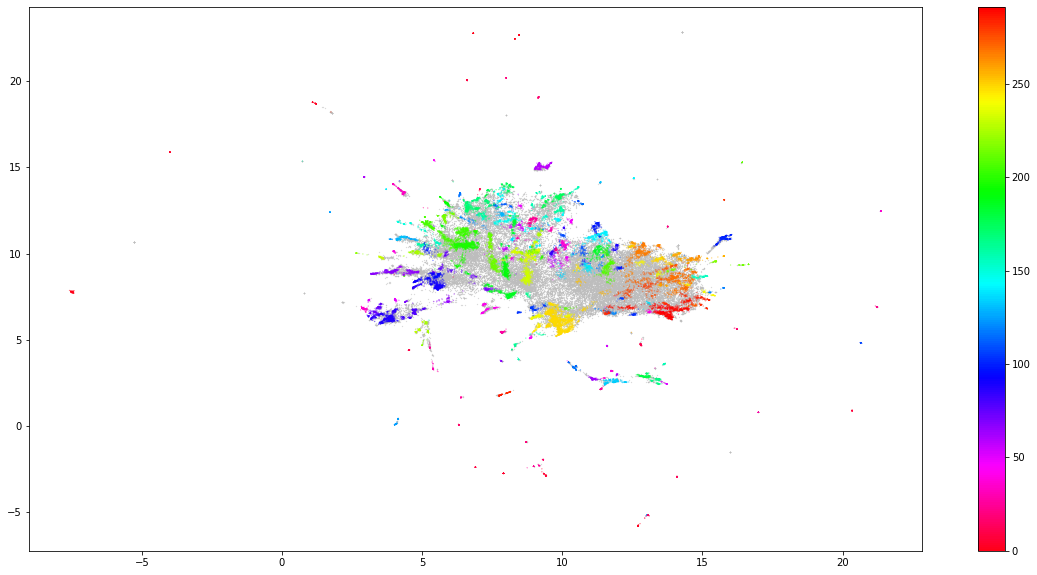

In [18]:
# To visualize the resulting clusters, reduce the dimensionality to 2 and visualize the outliers as grey points

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

# Topic Creation

## c-TF-IDF

In [19]:
docs_df = pd.DataFrame(sentences, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [20]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(sentences[::10]))

## Topic Representation


In [21]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(15)

,Topic,Size
0,-1,50410
249,248,1640
198,197,651
89,88,619
234,233,507
207,206,488
102,101,431
91,90,406
1,0,386
270,269,370


## Reduce Cluster Number

In [23]:
from sklearn.metrics.pairwise import cosine_similarity

for i in range(24):

    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(sentences)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(15)


,Topic,Size
0,-1,50459
222,221,1640
176,175,651
81,80,644
210,209,507
184,183,488
94,93,431
83,82,406
1,0,386
240,239,370


In [24]:
print("Topic Number after reduction:", topic_sizes.shape[0])

Topic Number after reduction: 262


# Display Clusters for Topic Analysis

## Print out the Clusters

In [29]:
from pprint import pprint

index = topic_sizes['Topic'].iloc[1]

pprint(top_n_words[index][:12])
print()

pprint([sent for sent in sent_tokenize(docs_per_topic.Doc[index+1][:1200])], width=180)

[('final', 0.1201473873983707),
 ('week', 0.11782515010429576),
 ('grade', 0.0826900232734874),
 ('quizzes', 0.07986902243509132),
 ('weekly', 0.06912095899838884),
 ('10', 0.0670852583480535),
 ('exams', 0.058780231557535846),
 ('papers', 0.05850861634397788),
 ('paper', 0.05838745403317091),
 ('tests', 0.05407990374999552),
 ('midterm', 0.05254427113498678),
 ('20', 0.04960321053477523)]

['5 easy quizzes (3 at home online) (4 questions each) and a final.',
 'For the tests he chooses 5 random pieces from about 100.',
 'Our second midterm average was a 28%.',
 'The computer science department is week to begin with.',
 '3 exams with a cumulative final (all multiple choice).',
 'Your grade is based on four papers, as far as the readings go you only need to read what goes with the essays you want to write.',
 "The averages throughout the year so far have been 60's on everything.",
 'Three exams (lowest can be replaced by clicker score) and a final make up your grade.',
 'Three 5-page pap

In [31]:
index = topic_sizes['Topic'].iloc[2]

pprint(top_n_words[index][:12])
print()

pprint([sent for sent in sent_tokenize(docs_per_topic.Doc[index+1][:1200])], width=180)

[('students', 0.5096832830853644),
 ('cares', 0.4138028758043638),
 ('really', 0.13925662658345947),
 ('wants', 0.11107337995868823),
 ('genuinely', 0.10103383746893903),
 ('truly', 0.08286479359019852),
 ('student', 0.07841861751042477),
 ('succeed', 0.07405672507750563),
 ('help', 0.07060713481111071),
 ('willing', 0.04715996490375479),
 ('success', 0.043141582928783666),
 ('loves', 0.03603721124001564)]

['Sokalski is engaging and is invested in student success.',
 'Prof. Cahen is a very knowledgeable guy and sincerely cares about how his students do.',
 'He really cares about his students and loves to get involved in extracurricular projects.',
 "His door is always open to students and he's very willing to help with anything.",
 "One of the few genuinely good people I know ... actually cares about teaching the subject and the people he's teaching.",
 'Bulent was enthusiastic, very helpful and clearly cares about his students.',
 'Also, he really cares about his students!',
 'He rea

In [32]:
index = topic_sizes['Topic'].iloc[3]

pprint(top_n_words[index][:12])
print()

pprint([sent for sent in sent_tokenize(docs_per_topic.Doc[index+1][:1200])], width=180)

[('best', 0.6620235395995314),
 ('professors', 0.35496871863090235),
 ('professor', 0.3066532985401281),
 ('ve', 0.29946462994849216),
 ('far', 0.15620768243588268),
 ('dr', 0.0741120442177326),
 ('probably', 0.0567959629887183),
 ('greatest', 0.05507231490347427),
 ('hands', 0.048693659907009086),
 ('prof', 0.04652135019544428),
 ('years', 0.04502697832160136),
 ('teachers', 0.04301078199026585)]

["Deb is the BEST professor i've had in college.",
 'I honestly can say that Professor Mackey is the best professor I have ever had.',
 "Easily one of the best professors I've had.",
 'best professor ever One of the best professors I have ever had.',
 "One of the greatest professors I've ever had.",
 'Professor Walsh is absolutely one of the best professors at UVA.',
 "Professor Boettiger is one of the best professors I've had so far at UNC.",
 'Overall, probably the best choice for biochem at UNC.',
 'She is probably one of the best professors for ENGL105.',
 'He is absolutely one of the be

In [34]:
index = topic_sizes['Topic'].iloc[4]

pprint(top_n_words[index][:12])
print()

pprint([sent for sent in sent_tokenize(docs_per_topic.Doc[index+1][:1200])], width=180)

[('read', 0.14908319290045433),
 ('book', 0.129402928240613),
 ('class', 0.11453582194368048),
 ('notes', 0.09365354339555523),
 ('study', 0.09133202455353284),
 ('textbook', 0.08295351625494601),
 ('exams', 0.08014249397011583),
 ('homework', 0.07611833161313411),
 ('lecture', 0.06702113408908439),
 ('sure', 0.06314465107323121),
 ('exam', 0.05964142135055464),
 ('tests', 0.05737864933898007)]

['If you complete the hw and understand it, the exams are simply re-worded hw probs.',
 'Just make sure you do the reading and go to class (a lot of the test questions come from lecture.)',
 'Tests, rec sec, and papers are your grade.',
 'Just go to class and do the readings.',
 "Go to class and you'll know the information!",
 'You just gotta show up and listen to the book.',
 'That being said, get ready to read if you take this class.',
 'Discussions =professor trying to relate the topics that we are discussing in class.',
 'She goes straight by the book.',
 'He basically recites the readings 

In [35]:
index = topic_sizes['Topic'].iloc[5]

pprint(top_n_words[index][:12])
print()

pprint([sent for sent in sent_tokenize(docs_per_topic.Doc[index+1][:1200])], width=180)

[('class', 0.34220168560948927),
 ('fun', 0.3176977044850838),
 ('interesting', 0.2707969370599525),
 ('great', 0.11941313398419366),
 ('makes', 0.10132210042456181),
 ('good', 0.09083776501146486),
 ('overall', 0.08170898315779579),
 ('funny', 0.07120109953094952),
 ('amazing', 0.06698718178761671),
 ('awesome', 0.06243739273682795),
 ('enjoyable', 0.06056847612724808),
 ('really', 0.05630854546910087)]

['Very fun and chill class The in-class composition projects are a lot of fun as well.',
 'A lot of fun, a really interesting class, taught by a man who knows his stuff and can present it clearly.',
 'The class is interesting and he is really funny.',
 'This class was awesome!',
 'his sense of humor makes class fun.',
 'This is a great class.',
 "Aside from grades, hes very entertaining cultural events and time periods you'll enjoy this class and he makes it very interesting.",
 'Super interesting class.',
 "A good class to take 'for fun'.",
 'a very interesting class!',
 'such a grea

In [36]:
index = topic_sizes['Topic'].iloc[6]

pprint(top_n_words[index][:12])
print()

pprint([sent for sent in sent_tokenize(docs_per_topic.Doc[index+1][:1200])], width=180)

[('worst', 0.99178356545613),
 ('professor', 0.28670081013231663),
 ('ve', 0.24772412850887374),
 ('teacher', 0.19602981248322224),
 ('far', 0.12042223155446584),
 ('professors', 0.09355702983837344),
 ('taken', 0.0772970752815421),
 ('ive', 0.05998407770108738),
 ('teachers', 0.05594750973360668),
 ('seen', 0.050936952265377686),
 ('university', 0.049851074775293824),
 ('life', 0.046393949865602906)]

["Chang is the worst professor I've had at UVA!",
 'Without question, this is the worst class I have taken in my entire academic career.',
 'WORST professor ever.',
 'Worst prof in my Carolina career Best prof for the worst class.',
 "Buck Goldstein's Econ 125 is one of the worst classes I have ever taken.",
 "One of the worst professors I've had at Carolina (I'm a Senior).",
 "Professor Ji is absolutely the worst professor I've had at UNC.",
 "Worst professor I've ever had in so many ways.",
 "Besides David Jones, the worst professor I've had at UNC.",
 'Professor Howe was the worst pro

In [37]:
index = topic_sizes['Topic'].iloc[7]

pprint(top_n_words[index][:12])
print()

pprint([sent for sent in sent_tokenize(docs_per_topic.Doc[index+1][:1200])], width=180)

[('students', 0.5030536100176212),
 ('cares', 0.39159698697931655),
 ('really', 0.15649314760360009),
 ('wants', 0.11194656685320473),
 ('genuinely', 0.09825518420080627),
 ('truly', 0.08514729110756189),
 ('help', 0.06748816380814825),
 ('loves', 0.06541940250309423),
 ('student', 0.045757159589002804),
 ('passionate', 0.04471569677949641),
 ('success', 0.04086061356835146),
 ('succeed', 0.03762677648900657)]

["She's very helpful and really cares how about your well-being in the class.",
 'She will do anything to help her students and is so clearly interested in and good at what she does!',
 "She is very receptive to students' ideas and encourages independent research.",
 "She's hilarious and really cares about her students.",
 'Dr. Current genuinely cares about her students and wants them to succeed.',
 'She is really caring for her students and will work with them fi a problem arises.',
 "She's very nice and seems to care about the students.",
 'Dr. Haskin really seems to care abou

In [38]:
index = topic_sizes['Topic'].iloc[8]

pprint(top_n_words[index][:12])
print()

pprint([sent for sent in sent_tokenize(docs_per_topic.Doc[index+1][:1200])], width=180)

[('comments', 4.893088811565543),
 ('projects', 0.014336697393736629),
 ('über', 0.0),
 ('examine', 0.0),
 ('exaggerating', 0.0),
 ('exaggeration', 0.0),
 ('exam', 0.0),
 ('exam2', 0.0),
 ('examens', 0.0),
 ('examination', 0.0),
 ('examined', 0.0),
 ('exaggerate', 0.0)]

['No Comments No Comments No Comments No Comments No Comments No Comments No Comments No Comments No Comments No Comments No Comments No Comments No Comments No Comments No '
 'Comments No Comments No Comments No Comments No Comments No Comments No Comments No Comments No Comments No Comments No Comments No Comments No Comments No Comments No Comments '
 'No Comments No Comments No Comments No Comments No Comments No Comments No Comments No Comments No Comments No Comments No Comments No Comments No Comments No Comments No '
 'Comments No Comments No Comments No Comments No Comments No Comments No Comments No Comments No Comments No Comments No Comments No Comments No Comments No Comments No Comments '
 'No Comments No

In [39]:
index = topic_sizes['Topic'].iloc[9]

pprint(top_n_words[index][:12])
print()

pprint([sent for sent in sent_tokenize(docs_per_topic.Doc[index+1][:1200])], width=180)

[('good', 0.16604917474742525),
 ('disorganized', 0.14232992310135323),
 ('waste', 0.12611686152211),
 ('helpful', 0.10135757372406076),
 ('time', 0.0838200489823093),
 ('teacher', 0.06848266819711823),
 ('like', 0.06466114653216502),
 ('did', 0.06014116937626045),
 ('professor', 0.05750722726558777),
 ('lacks', 0.05069887724385696),
 ('unclear', 0.047693569495270316),
 ('didn', 0.04697410877127659)]

['Not a fun class to be in.',
 "Idk, she didn't make it interesting enough to keep my attention.",
 'He does not explain things well at all.',
 'He is not good at teaching.',
 'Pop quizzes were not good either.',
 'Nobody did well on it.',
 'Unfortunately  testsquizzes do not give partial credit.',
 'Not a great professor.',
 'Jed is not a great professor.',
 'So unsatisfied.',
 'Waste of time.',
 "I don't know why her ratings are so low.",
 "Her advice and feedback wasn't helpful at all.",
 'She lacks professionalism and a passion for teaching.',
 "First of all, she's NOT a good lecturer

In [40]:
index = topic_sizes['Topic'].iloc[10]

pprint(top_n_words[index][:12])
print()

pprint([sent for sent in sent_tokenize(docs_per_topic.Doc[index+1][:1200])], width=180)

[('lectures', 0.46219646221108246),
 ('interesting', 0.2580566058329122),
 ('funny', 0.11460502316543943),
 ('engaging', 0.09991919060387647),
 ('great', 0.08827630125831078),
 ('fun', 0.07847033791295085),
 ('entertaining', 0.07212093217625516),
 ('lecture', 0.056560111550603843),
 ('makes', 0.05643672815231799),
 ('really', 0.05271896808409707),
 ('good', 0.05037661450540317),
 ('amazing', 0.04167046065560865)]

["He also has a good sense of humor and knows when students aren't understanding his lecture.",
 'extremely interesting subject matter, interesting lectures.',
 'The lectures were interesting and useful to attend.',
 "His lectures are very interesting and he's a funny guy.",
 'Big Data &amp; Media Analysis was very interesting and super fun.',
 'Lecture was well structured and interesting.',
 'He does a great job of making you appreciate public policy.',
 'Good lectures too.',
 'His lectures are funny with personal anecdotes.',
 'Gives both great lectures and feedback.',
 'He

In [41]:
index = topic_sizes['Topic'].iloc[11]

pprint(top_n_words[index][:12])
print()

pprint([sent for sent in sent_tokenize(docs_per_topic.Doc[index+1][:1200])], width=180)

[('bad', 0.4895968332591189),
 ('hard', 0.2610852666246978),
 ('isn', 0.1853086986514126),
 ('difficult', 0.1308889781882525),
 ('accent', 0.11335869112440544),
 ('aren', 0.10812048453364745),
 ('class', 0.10286387314722065),
 ('tests', 0.08666219290957876),
 ('wasn', 0.08219805532618266),
 ('overall', 0.07444688460390331),
 ('grader', 0.05210897289466212),
 ('really', 0.04575760104404362)]

['A B is not hard.',
 "I really didn't think Ramirez was that bad.",
 'Tests are not too difficult if you put in the time studying.',
 'Not a hard class.',
 'the subject isnt too hard to understand.',
 'The class is good for a core requirement otherwise, nah.',
 "She's not that bad.",
 "Prof's accent really isn't that bad.",
 'above average.',
 'Not an impossible class!',
 "Good grader, the work load wasn't too bad or heavy.",
 'Exams are not too hard.',
 'Other than that, not a bad class.',
 'Not bad to look at either!',
 "Tests aren't too bad if you study.",
 "Her tests aren't very difficult.",
 

## Saving Cluster

In [ ]:
# save the clusters 
for index in range(1, 51):
  address = "/content/drive/My Drive/Rebuild my Professor/Clusters_xue_Mar7/" + str(index) + ".txt"
  doc_index = topic_sizes['Topic'].iloc[index]

  with open(address, "w") as f:
    f.write(docs_per_topic.Doc[doc_index+1])

In [ ]:
# try reading the clusters to make sure they are save in the correct format
for index in range(1, 51):
  address = "/content/drive/My Drive/Rebuild my Professor/Clusters_xue_Mar7/" + str(index) + ".txt"
  doc_index = topic_sizes['Topic'].iloc[index]
  with open(address, "r") as f:
    print(f.read())

In [ ]:
# save txt file above but we want csv file for readability

# read txt file of each cluster and load into csv
for index in range(1, 51):
  address = "/content/drive/My Drive/Rebuild my Professor/Clusters_xue_Mar7/" + str(index) + ".txt"
  with open(address, "r") as f:
    # tokenize
    sentences = sent_tokenize(f.read())
    df = pd.DataFrame(sentences)
    save_address = "/content/drive/My Drive/Rebuild my Professor/Clusters_xue_Mar7/" + str(index) + ".csv"
    df.to_csv(save_address)

# Clustering on Selected Sentences

- Participation
- Workload

Since we don't find "**participation**" and "**workload**" clusters when we run the clustering algorithm above, we want to re-cluster some chosen sentences based on the two categories. We first select some sentences based on their words composition and store them in the JSON files. Then we perform the clustering algorithm again, hoping to gain more insights into the data regarding the two categories. 



### Workload

In [42]:
# read data
import json

with open("/content/drive/My Drive/Rebuild my Professor/Workload.json") as f:
  data = json.load(f)
  print("We read",len(data), "sentences regarding workload.")

We read 113261 sentences regarding workload.


In [46]:
# import embedding model
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

In [47]:
# function for c_tf_idf calculation
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  

# functions for topic representation
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words


def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes


# function header for clustering based on input sentences
def topic_analysis(sentences):
    # embedding
    embeddings = model.encode(sentences, show_progress_bar=True)

    # umap
    umap_embeddings = umap.UMAP(n_neighbors=24, 
                            n_components=15,
                            # min_dist=0.24, 
                            metric='cosine').fit_transform(embeddings)
    # hdbscan
    cluster = hdbscan.HDBSCAN(min_cluster_size= 24,
                          min_samples = 15,
                          # cluster_selection_epsilon = 0.2,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)
                          
    # topic creation
    docs_df = pd.DataFrame(sentences, columns=["Doc"])
    docs_df['Topic'] = cluster.labels_
    docs_df['Doc_ID'] = range(len(docs_df))
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(sentences))

    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
    topic_sizes = extract_topic_sizes(docs_df); print(topic_sizes.head(15))

    return docs_per_topic, top_n_words, topic_sizes

In [ ]:
docs_per_topic, top_n_words, topic_sizes = topic_analysis(data)

In [ ]:
# analyze clusters and choose one that is most relatable to workload

from pprint import pprint

index = topic_sizes['Topic'].iloc[6]

pprint(top_n_words[index][:12])
print()

pprint([sent for sent in sent_tokenize(docs_per_topic.Doc[index+1][:1200])])

In [ ]:
# save #6 workload cluster above

address = "/content/drive/My Drive/Rebuild my Professor/Clusters_xue_Mar7/" + "workload" + ".csv"
doc_index = topic_sizes['Topic'].iloc[5]
sentences = sent_tokenize(docs_per_topic.Doc[doc_index+1])

with open(address, "w") as f:
    df = pd.DataFrame(sentences)
    df.to_csv(address)

### Participation

In [ ]:
with open("/content/drive/My Drive/Rebuild my Professor/Participation.json") as f:
  data_par = json.load(f)
  print("We read",len(data_par), "sentences regarding participation.")

docs_per_topic, top_n_words, topic_sizes = topic_analysis(data_par)

We read 122597 sentences regarding participation.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


     Topic   Size
0       -1  81185
227    226   2256
91      90   1989
368    367   1224
61      60   1195
327    326   1001
47      46    935
333    332    841
153    152    760
89      88    753
259    258    653
1        0    641
351    350    534
188    187    527
236    235    514


In [ ]:
# analyze clusters and choose one that is most relatable to participation

from pprint import pprint

index = topic_sizes['Topic'].iloc[16]

pprint(top_n_words[index][:12])
print()

pprint([sent for sent in sent_tokenize(docs_per_topic.Doc[index+1][:1200])])

[('fine', 0.6248175503695976),
 ('ll', 0.2695351788197904),
 ('class', 0.12578362045772123),
 ('notes', 0.11945071036643184),
 ('pay', 0.11153037540521053),
 ('attention', 0.10828350743821967),
 ('study', 0.1041044490026498),
 ('long', 0.10052034906140814),
 ('homework', 0.09193331463354794),
 ('just', 0.08552089346726328),
 ('read', 0.0755588712345817),
 ('participate', 0.05840983447565667)]

['As long as you do the work, participate in class, and watch the films, you '
 'will do fine.',
 'Summers is the man, and as long as you show up and contribute to class, '
 "you'll be fine.",
 'For tests, just know the review guide and which authors said what, and '
 "you'll be fine.",
 'Come to class and you will be fine.',
 "Classes were lecture heavy - study them and you'll do fine.",
 'As long as you study for his slides, will be fine, meaning getting an A.',
 "If you go to lecture (attendance taken) and do the readings you'll be fine.",
 "Skim the readings and come up with questions before 

In [ ]:
# save #5 cluster above (releated to workload)
address = "/content/drive/My Drive/Rebuild my Professor/Clusters_xue_Mar7/" + "workload2" + ".csv"
doc_index = topic_sizes['Topic'].iloc[5]
sentences = sent_tokenize(docs_per_topic.Doc[doc_index+1])
with open(address, "w") as f:
    df = pd.DataFrame(sentences)
    df.to_csv(address)

# save #12 cluster above (releated to workload)
address = "/content/drive/My Drive/Rebuild my Professor/Clusters_xue_Mar7/" + "workload3" + ".csv"
doc_index = topic_sizes['Topic'].iloc[12]
sentences = sent_tokenize(docs_per_topic.Doc[doc_index+1])
with open(address, "w") as f:
    df = pd.DataFrame(sentences)
    df.to_csv(address)


# save #15 cluster above (releated to participation)
address = "/content/drive/My Drive/Rebuild my Professor/Clusters_xue_Mar7/" + "participation1" + ".csv"
doc_index = topic_sizes['Topic'].iloc[15]
sentences = sent_tokenize(docs_per_topic.Doc[doc_index+1])
with open(address, "w") as f:
    df = pd.DataFrame(sentences)
    df.to_csv(address)

# save #16 cluster above (releated to participation)
address = "/content/drive/My Drive/Rebuild my Professor/Clusters_xue_Mar7/" + "participation2" + ".csv"
doc_index = topic_sizes['Topic'].iloc[16]
sentences = sent_tokenize(docs_per_topic.Doc[doc_index+1])
with open(address, "w") as f:
    df = pd.DataFrame(sentences)
    df.to_csv(address)
